In [1]:
import asterion
from asterion import models
import numpyro
import numpyro.distributions as dist
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from asterion.models import GlitchModel, HeGlitchFunction, CZGlitchFunction, AsyFunction
import arviz as az

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
track = pd.read_csv('../docs/source/tutorials/data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


Choose a star from the evolutionary track.

In [3]:
profile = track.loc[1008]

Extract modes from star.

In [4]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 551.94 muHz
delta_nu ~ 35.2 muHz


In [5]:
n_max = nu_max_sca / delta_nu_fit - 1.
n_max

14.68073766060638

In [6]:
n_max = int(nu_max_sca / delta_nu_fit - 1.)

n = np.arange(n_max - 7, n_max + 7)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

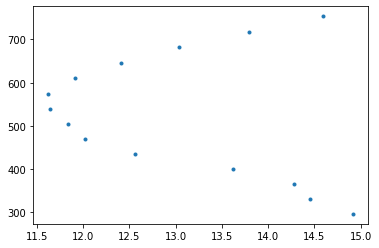

In [7]:
ax = plt.gca()
ax.plot(nu%delta_nu_fit, nu, '.');

In [8]:
from asterion.prior import TauPrior

In [9]:
delta_nu = (delta_nu_fit, 0.5)
nu_max = (nu_max_sca, 0.05*nu_max_sca)
teff = dist.Uniform(4000, 7000)

In [10]:
from jax import random

key = random.PRNGKey(0)
prior = TauPrior(nu_max, teff)
log_tau_he, log_tau_cz = prior.condition(key, kind='optimized', num_samples=1000)

In [11]:
background = AsyFunction(delta_nu)
he_glitch = HeGlitchFunction(nu_max, log_tau_he)
cz_glitch = CZGlitchFunction(nu_max, log_tau_cz)

In [12]:
model = GlitchModel(n, background, he_glitch, cz_glitch)

In [13]:
from asterion.inference import Inference

In [14]:
infer = Inference(model, nu=nu, seed=42)

In [15]:
infer.prior_predictive()

In [16]:
data = infer.get_data()

/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:349: UserWarning: Parameter 'phi_he' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:349: UserWarning: Parameter 'phi_cz' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \


In [17]:
from asterion.plotting import plot_corner, plot_glitch

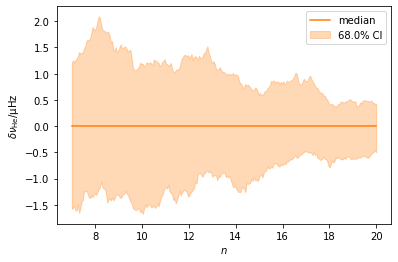

In [18]:
plot_glitch(data, group='prior');

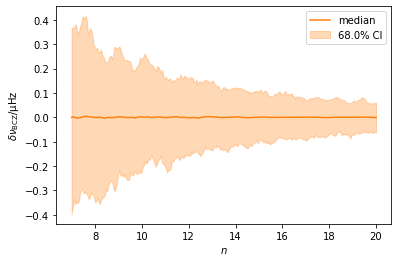

In [19]:
plot_glitch(data, group='prior', kind='CZ');

In [31]:
# import numpyro.distributions as dist
# he_glitch.phi = dist.VonMises(0.0, 0.1)
# cz_glitch.phi = dist.VonMises(0.0, 0.1)

# infer.sample(method='mcmc', 
#              mcmc_kwargs={'num_chains': 4, 
#                           'sampler_kwargs': {'dense_mass': True,
#                                              'target_accept_prob': .99},
#                           'num_warmup': 1500})

In [65]:
infer.sample(method='nested', 
             nested_kwargs={
                 'num_live_points': 150,
                 'depth': 7,
             })

/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:349: UserWarning: Parameter 'phi_he' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:349: UserWarning: Parameter 'phi_cz' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \


In [66]:
infer.posterior_predictive()

In [67]:
data = infer.get_data()

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:349: UserWarning: Parameter 'phi_he' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:349: UserWarning: Parameter 'phi_cz' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance d

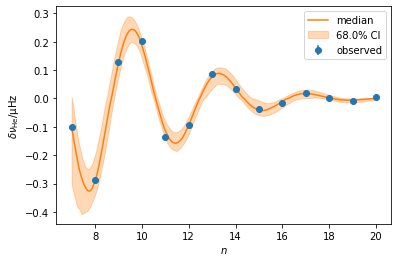

In [68]:
plot_glitch(data);

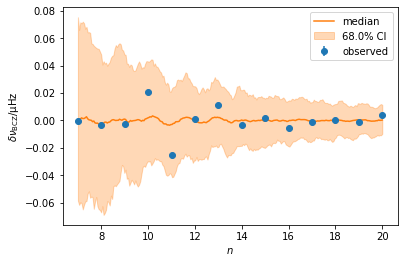

In [69]:
plot_glitch(data, kind='CZ');

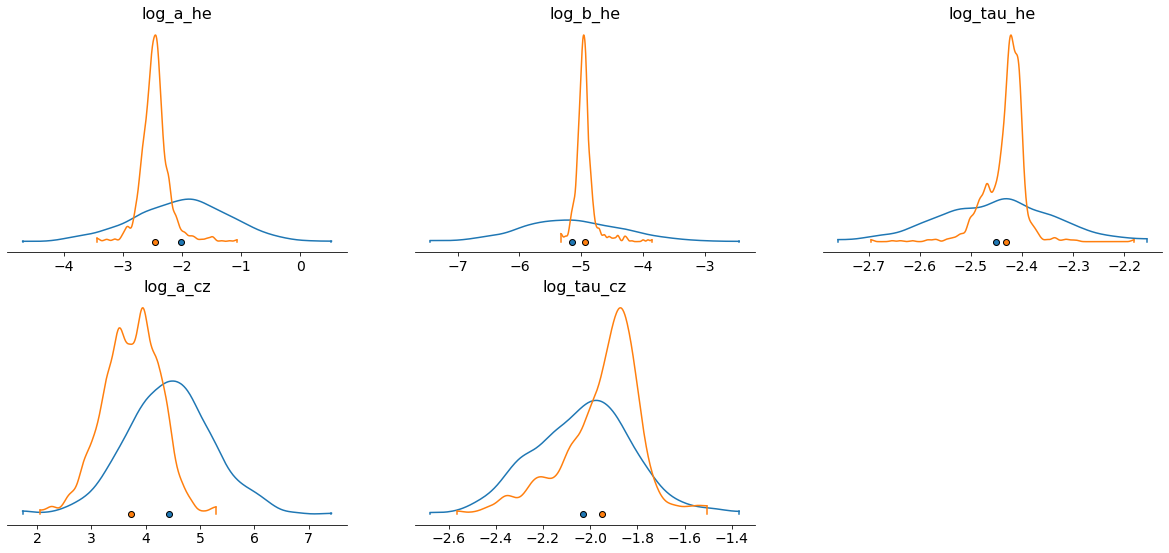

In [70]:
var_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'log_a_cz', 'log_tau_cz']
ax = az.plot_density(data, group='prior_predictive', var_names=var_names, hdi_prob=1.)
ax = az.plot_density(data, group='posterior', colors='C1', var_names=var_names, hdi_prob=1., ax=ax)

In [71]:
from asterion.data import get_table, get_summary

In [72]:
get_table(data, dims=(), fmt='astropy')

metric,a_cz,a_he,b_he,delta_nu,epsilon,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_he,tau_cz,tau_he
,uHz3,,Ms2,uHz,,dex(uHz3),dex,dex(Ms2),dex(Ms),dex(Ms),uHz,rad,rad,Ms,Ms
str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
mean,10350.0,0.0042,1.26e-05,35.26,1.362,3.73,-2.462,-4.941,-1.949,-2.432,0.0442,-0.46,0.78,0.012,0.00371
sd,15720.0,0.0048,9.6e-06,0.207,0.107,0.51,0.239,0.16,0.164,0.038,0.0291,1.63,1.79,0.0042,0.00032
16th,1730.0,0.0022,8.9e-06,35.061,1.25,3.24,-2.657,-5.053,-2.097,-2.467,0.0192,-2.2,-1.79,0.008,0.00341
50th,5600.0,0.0034,1.1e-05,35.252,1.361,3.75,-2.472,-4.96,-1.915,-2.424,0.0354,-0.75,1.43,0.0122,0.00376
84th,17630.0,0.0052,1.39e-05,35.484,1.467,4.25,-2.287,-4.858,-1.816,-2.405,0.0712,1.38,2.35,0.0153,0.00394


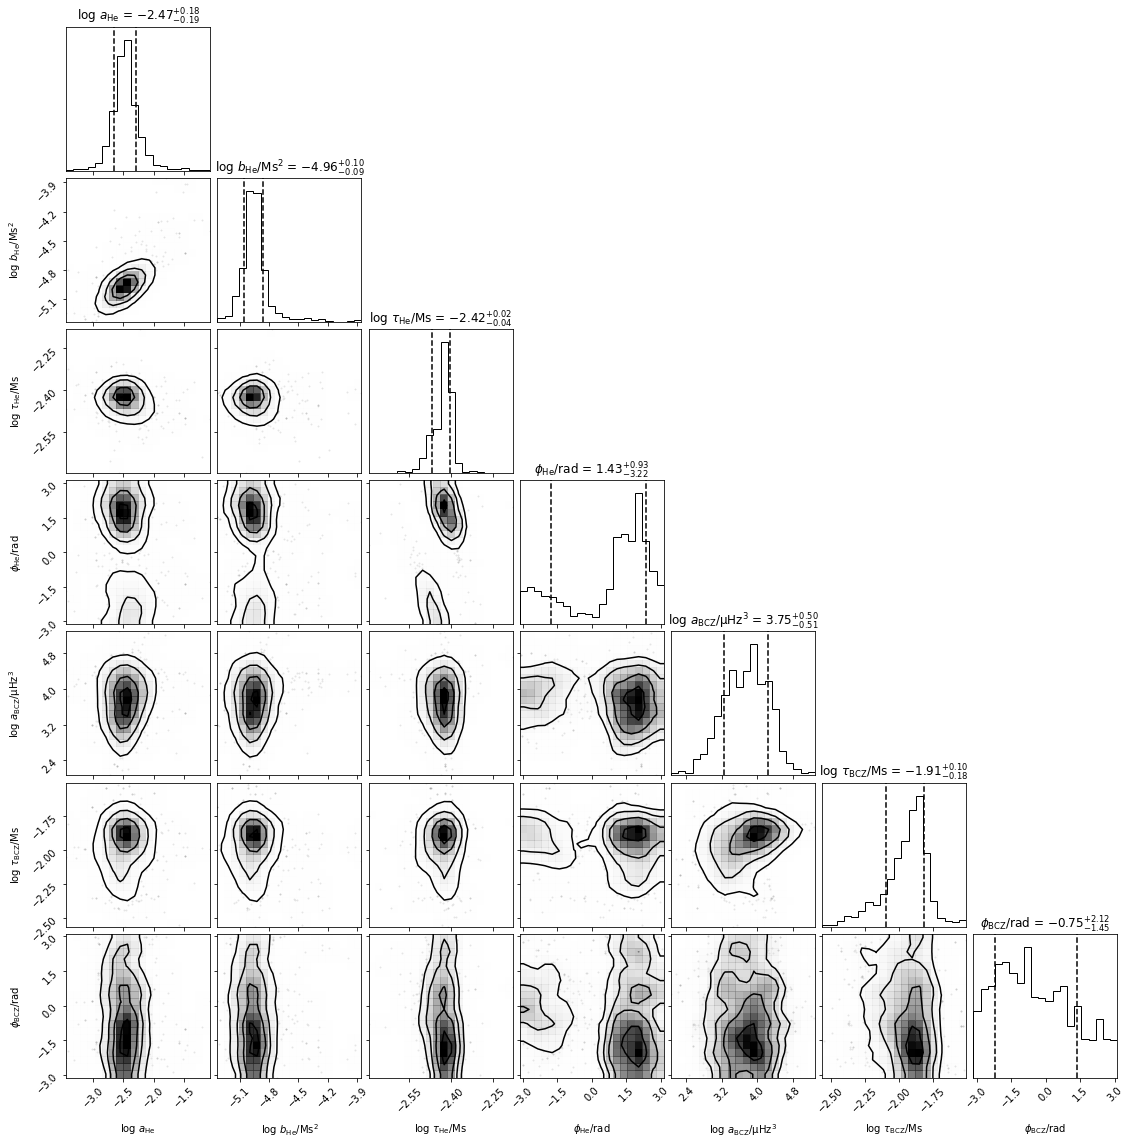

In [73]:
plot_corner(data, var_names=['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']);

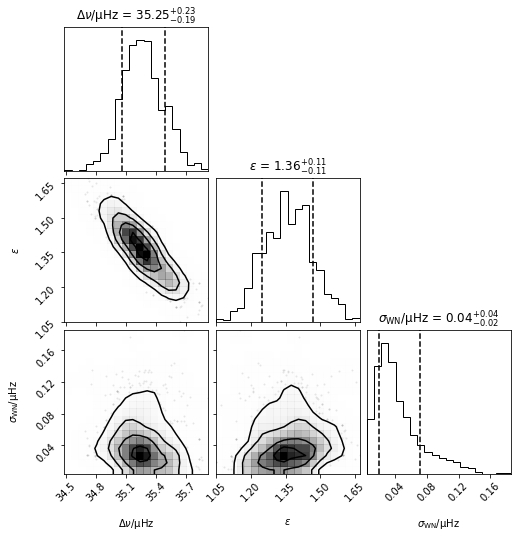

In [74]:
plot_corner(data, var_names=['delta_nu', 'epsilon', 'noise']);

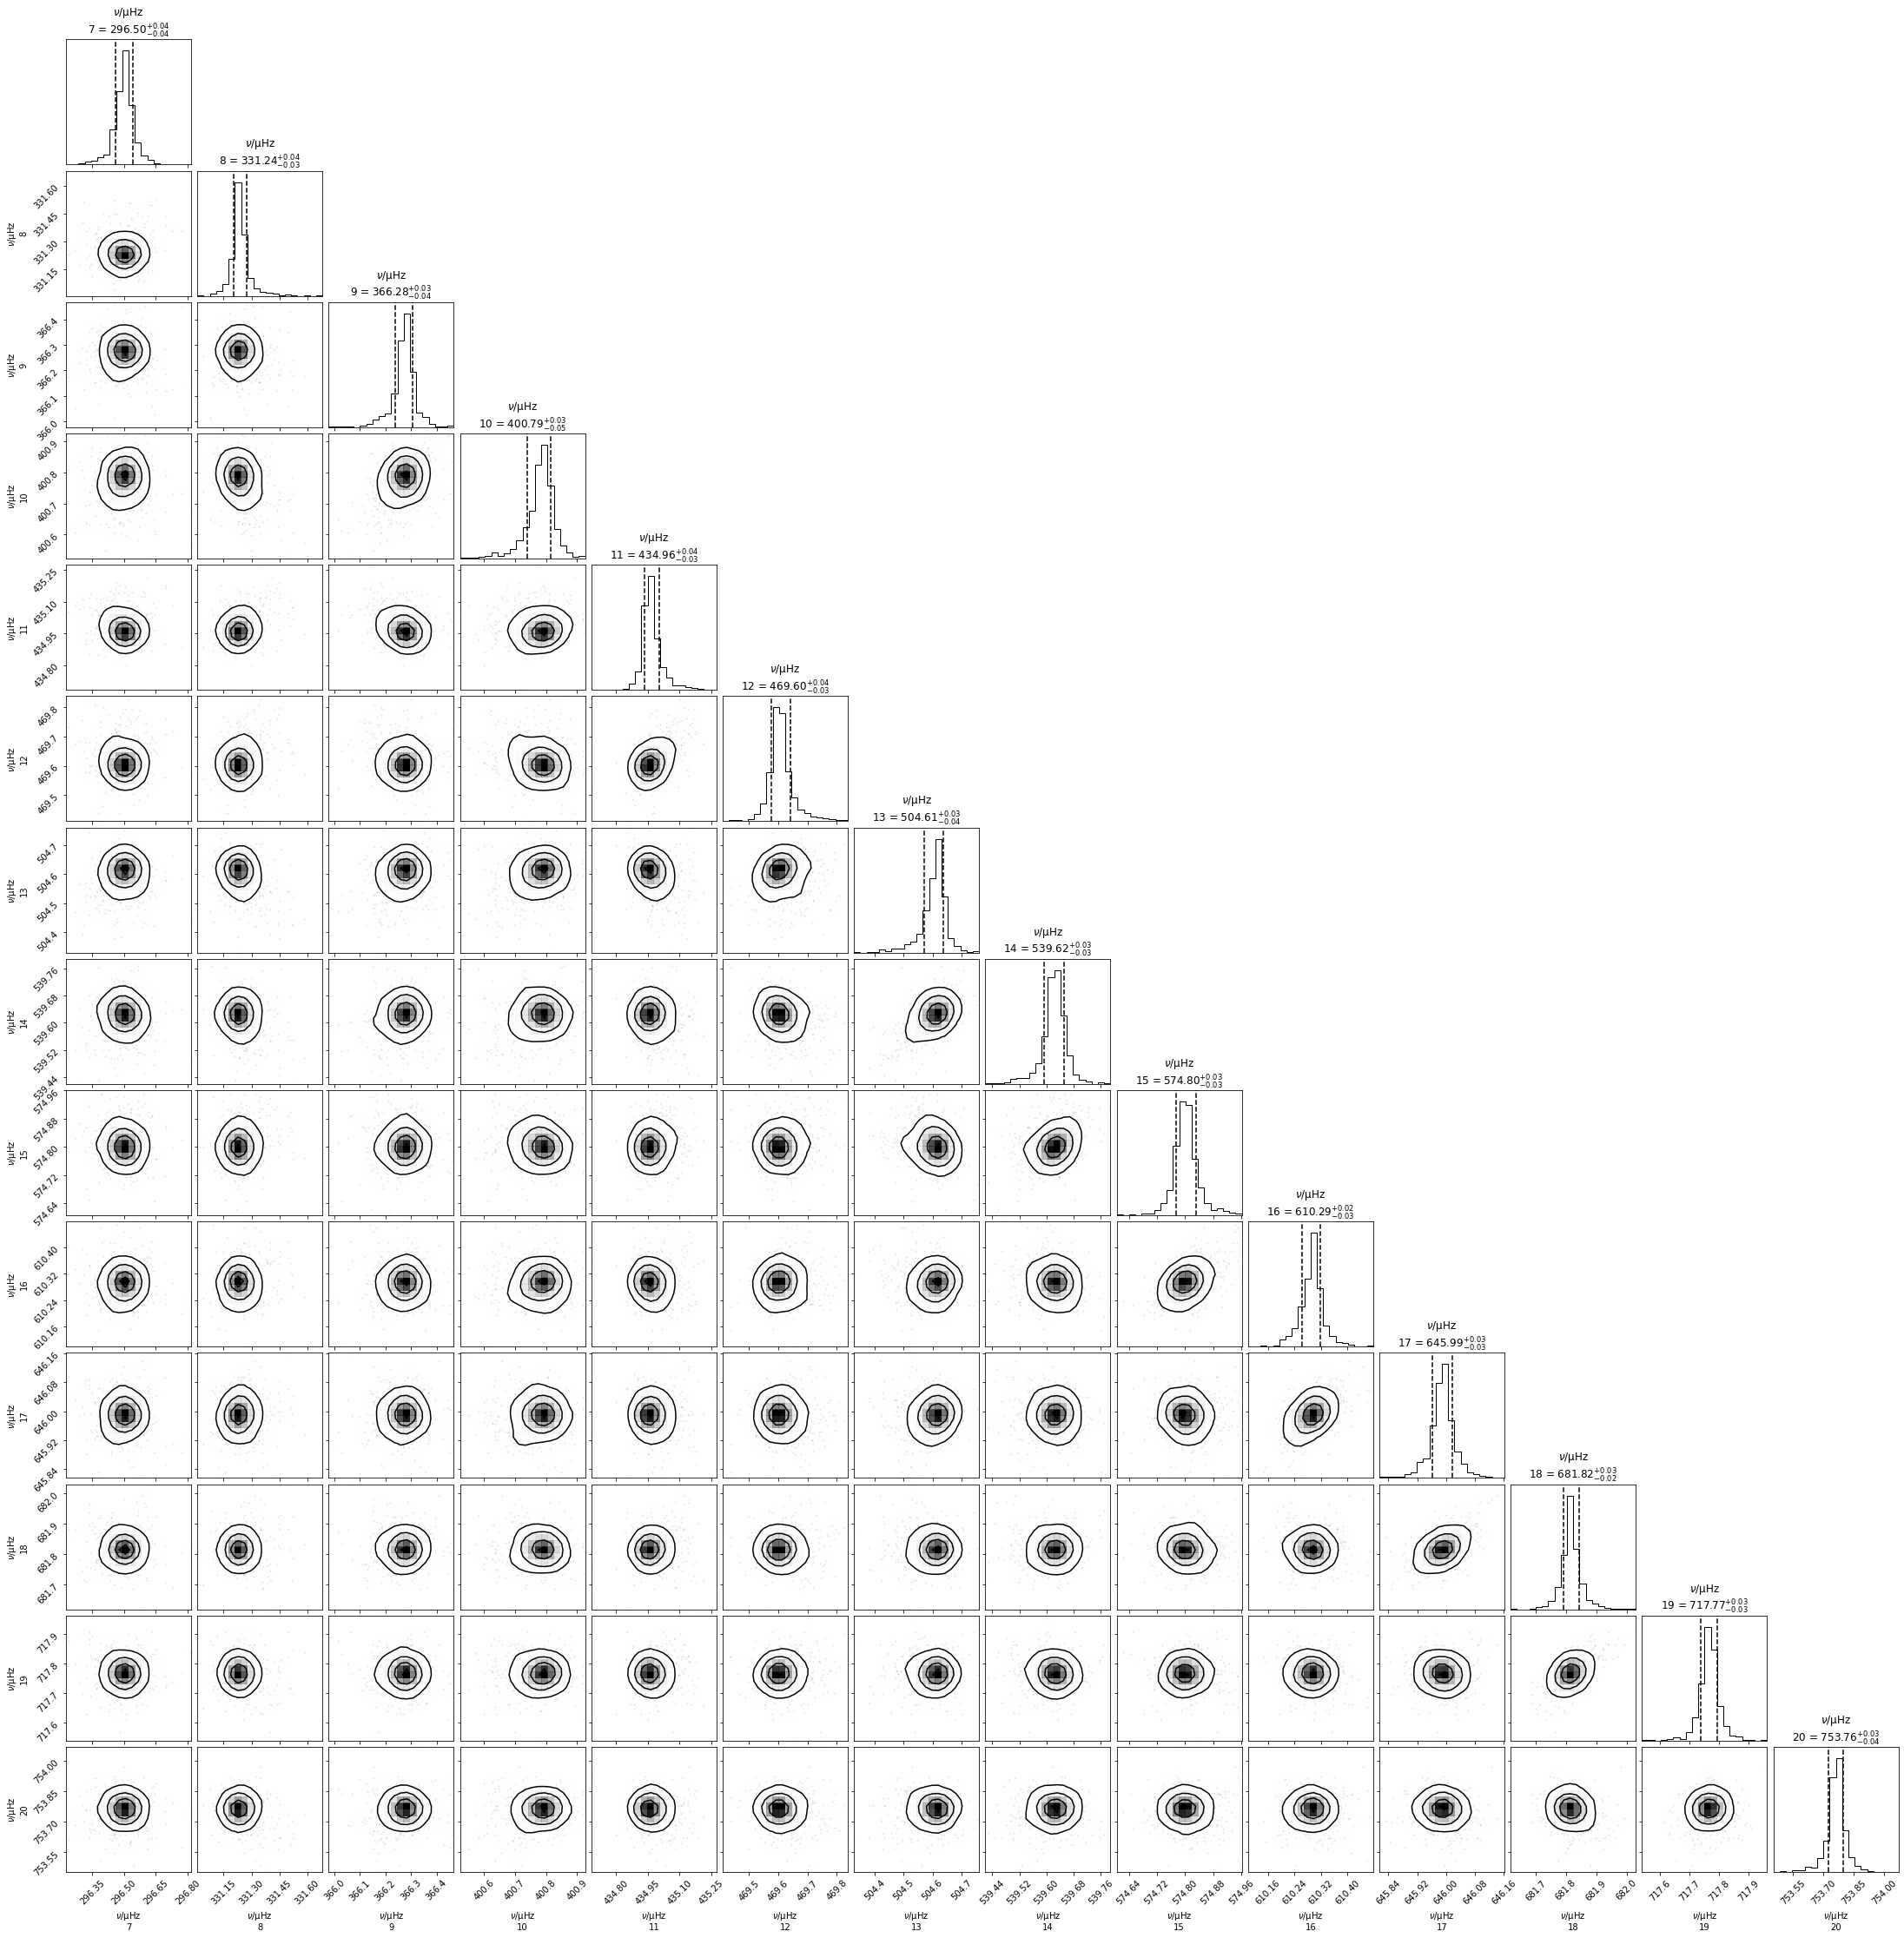

In [75]:
plot_corner(data, group='posterior_predictive', var_names=['nu']);

In [76]:
from jaxns.plotting import plot_diagnostics

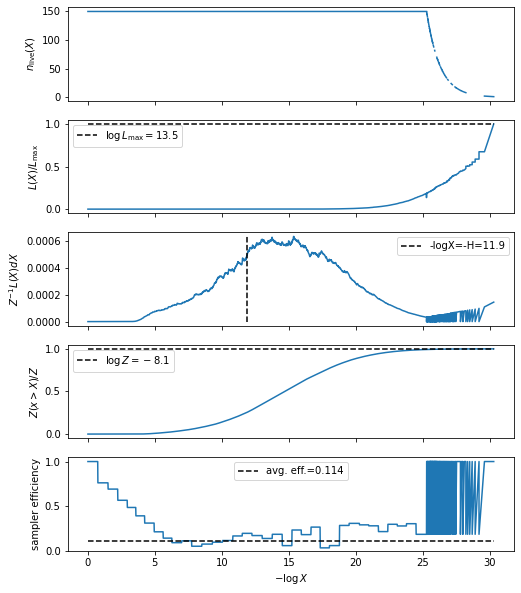

In [77]:
plot_diagnostics(infer.ns._results);

In [78]:
data.to_netcdf('data/inference_data.nc')

'data/inference_data.nc'